<a href="https://colab.research.google.com/github/epodkwan/growthfunction/blob/main/jaxtrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from typing import Sequence
import jax
import optax
import numpy as np
import jax.numpy as jnp
from jax import jit,random
from flax import linen as nn
from flax.training import train_state,checkpoints
import matplotlib.pyplot as plt

In [ ]:
class SimpleMLP(nn.Module):
    features:Sequence[int]

    @nn.compact
    def __call__(self,inputs):
        x=inputs
        for i,feat in enumerate(self.features):
            x=nn.Dense(feat)(x)
            if i != len(self.features)-1:
                x=nn.relu(x)
        return x

In [ ]:
layer_sizes=[64,256,256,256]
learning_rate=1e-6
epochs=2500000
model=SimpleMLP(features=layer_sizes)
temp=jnp.ones(2)
params=model.init(random.PRNGKey(0),temp)
tx=optax.adam(learning_rate=learning_rate)
opt_state=tx.init(params)

In [ ]:
def npy_loader(path):
    return jnp.load(path)

In [ ]:
@jit
def mse_loss(params,x,y_ref):
    preds=model.apply(params,x)
    diff=preds-y_ref
    return jnp.mean(diff*diff)

In [ ]:
@jit
def train_step(params,opt_state,x,y_ref):
    loss,grads=jax.value_and_grad(mse_loss,argnums=0)(params,x,y_ref)
    updates,opt_state=tx.update(grads,opt_state)
    params=optax.apply_updates(params,updates)
    return loss,params,opt_state

In [ ]:
@jit
def epoch_step(x_train,y_train,params,opt_state,order):
    order=random.permutation(random.PRNGKey(i),order)
    train_loss=0
    for j in range(25):
        x_batch=x_train[order[32*j:32*(j+1)-1],:]
        y_batch=y_train[order[32*j:32*(j+1)-1],:]
        loss,params,opt_state=train_step(params,opt_state,x_batch,y_batch)
        train_loss=train_loss+loss
    return train_loss,params

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_data=npy_loader("/content/drive/My Drive/Colab Notebooks/cosmo.npy")
raw_input_result=npy_loader("/content/drive/My Drive/Colab Notebooks/combined.npy")
input_result=jnp.log(raw_input_result)
x_train=jnp.stack((input_data[0:800,0],input_data[0:800,2]),axis=1)
y_train=input_result[0:800,:]
x_validate=jnp.stack((input_data[800:900,0],input_data[800:900,2]),axis=1)
y_validate=input_result[800:900,:]

1000 0.07427143
2000 0.05977141
3000 0.04845557
4000 0.036711026
5000 0.02377129
6000 0.011164287
7000 0.002780189
8000 0.00030399676
9000 0.00010355284
10000 6.0699535e-05
11000 4.368984e-05
12000 3.3704153e-05
13000 2.5063255e-05
14000 1.893607e-05
15000 1.3917989e-05
16000 1.11651525e-05
17000 9.52677e-06
18000 8.349344e-06
19000 7.2392877e-06
20000 6.399995e-06
21000 5.688885e-06
22000 5.2419655e-06
23000 4.877092e-06
24000 4.5671454e-06
25000 4.1990475e-06
26000 3.7217133e-06
27000 3.3702195e-06
28000 3.143938e-06
29000 2.9755781e-06
30000 2.8093243e-06
31000 2.6529258e-06
32000 2.4941558e-06
33000 2.33739e-06
34000 2.2400757e-06
35000 2.1754183e-06
36000 2.099202e-06
37000 1.9227684e-06
38000 1.8344706e-06
39000 1.8089593e-06
40000 1.8953189e-06
41000 1.8955458e-06
42000 1.8995753e-06
43000 1.9282488e-06
44000 1.8894068e-06
45000 1.7549531e-06
46000 1.644315e-06
47000 1.5500623e-06
48000 1.5353435e-06
49000 1.4786617e-06
50000 1.4289238e-06
51000 1.400573e-06
52000 1.3209163e-06


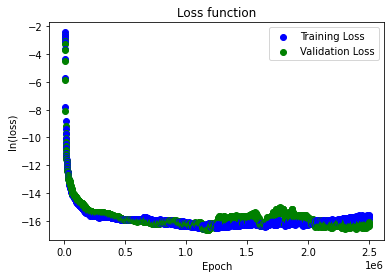

In [ ]:
order=jnp.arange(800)
for i in range(epochs):
    train_loss,params=epoch_step(x_train,y_train,params,opt_state,order)
    if i % 1000 == 999:
        train_loss=train_loss/25
        validate_loss=mse_loss(params,x_validate,y_validate)
        print((i+1),validate_loss)
        plt.scatter((i+1),jnp.log(train_loss),c='b')
        plt.scatter((i+1),jnp.log(validate_loss),c='g')
print("Training ended")
state=train_state.TrainState.create(apply_fn=model.apply,params=params,tx=tx)
checkpoints.save_checkpoint(ckpt_dir="/content/drive/My Drive/Colab Notebooks",target=state,step=0,overwrite=True)
plt.xlabel("Epoch")
plt.ylabel("ln(loss)")
plt.title("Loss function")
plt.legend(["Training Loss","Validation Loss"])
plt.savefig("/content/drive/My Drive/Colab Notebooks/loss.png")
drive.flush_and_unmount()

In [ ]:
x_test=jnp.stack((input_data[900:1000,0],input_data[900:1000,2]),axis=1)
y_test=raw_input_result[900:1000,:]
y_pred=jnp.exp(model.apply(params,x_test))
print(y_pred)
error=abs(y_pred/y_test-1)
print("Max error =",jnp.max(error)*100,"%")

[[0.01183629 0.01205343 0.01226837 ... 0.9761126  0.98760927 1.0000379 ]
 [0.0127128  0.01293956 0.01316672 ... 0.9791749  0.9892708  0.99983263]
 [0.01397513 0.01422593 0.01447953 ... 0.9837233  0.99173945 0.9998925 ]
 ...
 [0.01429367 0.01454436 0.01479723 ... 0.98357326 0.99169636 0.9998683 ]
 [0.01575749 0.01603743 0.01631946 ... 0.98716205 0.99329776 0.99984187]
 [0.01208342 0.01230085 0.01251952 ... 0.9772373  0.9882875  0.99996006]]
Max error = 0.4330516 %
